In this notebook, we build some k Nearest Neighbor models using Target Encoded claissification features

## Importing packages and data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [6]:
df=pd.read_csv('clean_data_3.csv')

## Splitting the data

In [7]:
train, val = train_test_split(df,
                              test_size=0.1,
                              stratify=df["Y"],
                              shuffle=True,
                              random_state=123)

## A first model
Using all of the features we found to have a strong or weak correlation during EDA

Using kfold cross-validation, we find that k=1 is the best by a small margin, and the type of metric used doesn't seem to matter.

This model as a much higher accuracy but lower recall than the baseline model.


In [8]:
def make_x(n):
    '''makes a list of the form [1,1,1,1,1,2,2,2,2,2,...,n,n,n,n,n]
    (5 of each)'''
    answer=[]
    for i in range(n):
        j=i+1
        answer=answer+[j,j,j,j,j]
    return(answer)

In [9]:
features2=['SEX_TE', 
           'EDUCATION_TE', 
           'MARRIAGE_TE', 
           'PAY_1_TE',
           'PAY_AMT1',
           'AGE_BY10_TE', 
           'AVE_PAY', 
           'AGE/LIM', 
           'AVE_BILL_AMT',
           'AVE_BILL_AMT/LIM', 
           'AVE_PAY_AMT',
           'AVE_PAY_AMT/LIM',  
           'AVE_PAY/BILL', 
           'UNPAID_MONTHS']

#### Finding an optimal $k$

In [10]:
def knn_1(j, splits):
    '''goes through k in range(1,j+1) on kNN models on training set.
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    
    accs=np.zeros((j,splits))
    recs = np.zeros((j,splits))
    for i in range(j):
        x=0
        for train_index, test_index in kfold.split(train[features2], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1*(i+1))
            kNN.fit(
                train.iloc[train_index][features2],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][features2]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [11]:
metrics=knn_1(5,5)

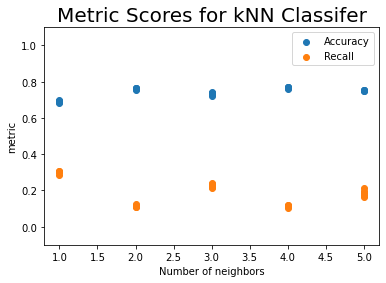

In [12]:
#plt.figure(figsize=(8,6))

plt.scatter(make_x(5),
           metrics[0],
           label='Accuracy')

plt.scatter(make_x(5),
           metrics[1],
           label='Recall')

plt.title('Metric Scores for kNN Classifer', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('metric')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [13]:
np.mean(metrics[0])

0.7416666666666666

In [14]:
np.mean(metrics[1])

0.18898133624888738

#### Should the distances be weighted?

In [15]:
def knn_3(splits):
    '''
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    weights=['uniform','distance']
    
    accs=np.zeros((2,splits))
    recs = np.zeros((2,splits))
    for i in range(2):
        x=0
        for train_index, test_index in kfold.split(train[features2], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1,
                                       weights=weights[i]
                                      )
            kNN.fit(
                train.iloc[train_index][features2],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][features2]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [16]:
metrics3=knn_3(5)

metrics3

(array([[0.69166667, 0.69518519, 0.68814815, 0.68351852, 0.69814815],
        [0.69166667, 0.69518519, 0.68814815, 0.68351852, 0.69814815]]),
 array([[0.30209205, 0.28535565, 0.30653266, 0.30988275, 0.2998325 ],
        [0.30209205, 0.28535565, 0.30653266, 0.30988275, 0.2998325 ]]))

## Deciding if we should really use all the features

Maybe we should have done this before finding $k$...

So if we were to use the powerset of features1 to determine the best subset of features1 to use, we would create and compare 16,384 models.  I don't have the computing power for that, so let's be smarter about which subset to use.

Let's create a series of models that uses the average of each feature individually to decide, and compare the accuracy/recall of those.

We'll ignore marriage and education because those numbers don't actually mean anything, so taking an average doesn't make sense.  We'll leave IN sex because it's binary.

In [17]:
all_metrics=[]

for feature in features2:
    ave=train[feature].mean()
    
    pred=[]
    accs=[]
    recs=[]
    
    #Assign the prediction to the observation based on which side of the average it is on
    for i in range(len(train)):
        if train.groupby(['Y'])[feature].mean()[0] < ave:
            if train.iloc[i][feature] <=ave:
                pred.append(0)
            else: pred.append(1)
        else:
            if train.iloc[i][feature] > ave:
                pred.append(0)
            else: pred.append(1)
        
    #find the accuracy and recall
    accuracy = accuracy_score(train['Y'],pred)
    recall=recall_score(train['Y'],pred)
    accs.append(accuracy)
    recs.append(recall)
    
    #print the findings
    print(feature)
    print('Accuracy: '+ str(accuracy))
    print('Recall: ' + str(recall))
    print('\n')
    
    #save the findings into the output
    all_metrics.append(accs)
    all_metrics.append(recs)
        

SEX_TE
Accuracy: 0.5744074074074074
Recall: 0.4362022772940388


EDUCATION_TE
Accuracy: 0.45155555555555554
Recall: 0.6905559276624247


MARRIAGE_TE
Accuracy: 0.5295925925925926
Recall: 0.4956463496316142


PAY_1_TE
Accuracy: 0.7805555555555556
Recall: 0.5190890823844608


PAY_AMT1
Accuracy: 0.38381481481481483
Recall: 0.8591761553918286


AGE_BY10_TE
Accuracy: 0.445
Recall: 0.6619223040857334


AVE_PAY
Accuracy: 0.4781111111111111
Recall: 0.7268921634293369


AGE/LIM
Accuracy: 0.5681481481481482
Recall: 0.45160750167448094


AVE_BILL_AMT
Accuracy: 0.4003703703703704
Recall: 0.709310113864702


AVE_BILL_AMT/LIM
Accuracy: 0.575037037037037
Recall: 0.549899531145345


AVE_PAY_AMT
Accuracy: 0.41455555555555557
Recall: 0.8369055592766242


AVE_PAY_AMT/LIM
Accuracy: 0.39874074074074073
Recall: 0.7285666443402545


AVE_PAY/BILL
Accuracy: 0.49374074074074076
Recall: 0.6756530475552579


UNPAID_MONTHS
Accuracy: 0.7309629629629629
Recall: 0.6513730743469525




In [18]:
len(all_metrics)

28

In [19]:
recall_scores=[all_metrics[2*i+1] for i in range(14)]
accuracy_scores=[all_metrics[2*i] for i in range(14)]

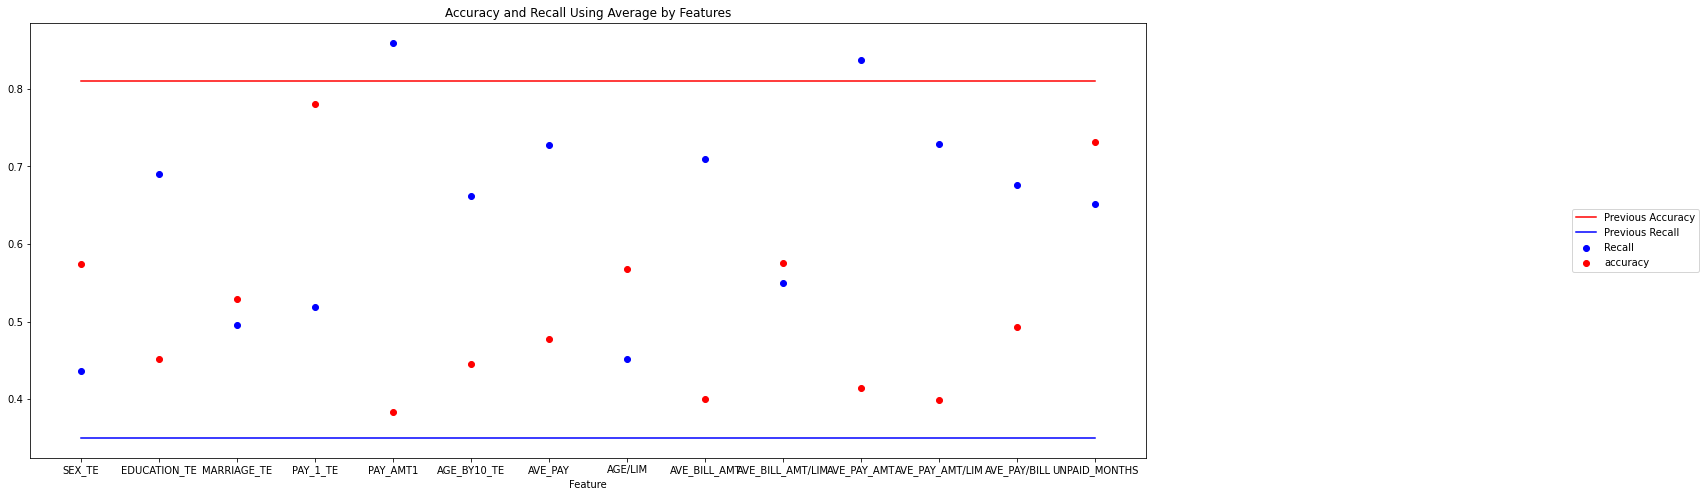

In [20]:
plt.figure(figsize=(20,8))

plt.scatter(features2,
           recall_scores,
           label='Recall',
           color='b')

plt.scatter(features2,
           accuracy_scores,
           label='accuracy',
           color='red')

plt.plot([features2[0], features2[-1]],
        [.81, .81],
        label='Previous Accuracy',
        color='red')


plt.plot([0,13],
        [0.35, 0.35],
        label='Previous Recall',
        color='blue')

plt.title('Accuracy and Recall Using Average by Features')

plt.xlabel('Feature')

plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))

plt.show()

If accuracy is the only important thing to us, the best features to use are: unpaid_months, age_by10 (what?!), sex, ave_bill_amt, and age/lim

If recall is the only important thing to us, the best features to use are: pay_amt1, ave_pay_amt, pay_1, ave_pay, and ave_pay_amt/lim

If recall and accuracy are equally important to us, the best featuers to use are:
unpaid_months, ave_pay/bill, ave_pay, ave_bill_amt/lim

So, let's build some knn models using just these features

In [21]:
features_acc=['UNPAID_MONTHS', 'AGE_BY10', 'SEX', 'AVE_BILL_AMT', 'AGE/LIM']
features_rec=['PAY_AMT1', 'AVE_PAY_AMT', 'PAY_1', 'AVE_PAY', 'AVE_PAY_AMT/LIM']
features_both=['UNPAID_MONTHS', 'AVE_PAY/BILL', 'AVE_PAY', 'AVE_BILL_AMT/LIM']

In [23]:
def knn_4(fs, j, splits):
    '''goes through k in range(1,j+1) on kNN models on training set.
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    
    accs=np.zeros((j,splits))
    recs = np.zeros((j,splits))
    for i in range(j):
        x=0
        for train_index, test_index in kfold.split(train[fs], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1*(i+1))
            kNN.fit(
                train.iloc[train_index][fs],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][fs]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [24]:
knn_foracc=knn_4(features_acc,5,5)
knn_forrec=knn_4(features_rec,5,5)
knn_forboth=knn_4(features_both,5,5)

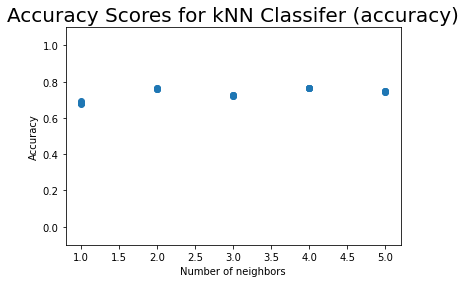

In [25]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_foracc[0]).reshape(1,-1))

#plt.scatter(range(1,5), np.mean(knn_foracc[0], axis=1), label='Average')

#plt.plot([1,5],
#        [accuracy_score(train['Y'],baseline_pred['Y']),accuracy_score(train['Y'],baseline_pred['Y'])],
#        label='Baseline')

plt.title('Accuracy Scores for kNN Classifer (accuracy)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.ylim(-0.1,1.1)

#plt.legend()

plt.show()

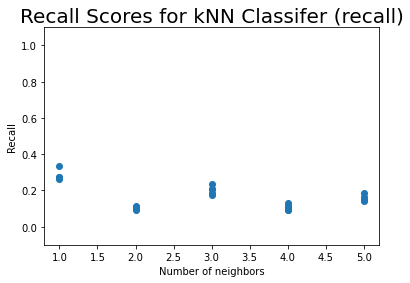

In [26]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_forrec[1]).reshape(1,-1))

#plt.scatter(range(1,5), np.mean(knn_foracc[0], axis=1), label='Average')



plt.title('Recall Scores for kNN Classifer (recall)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)



plt.show()

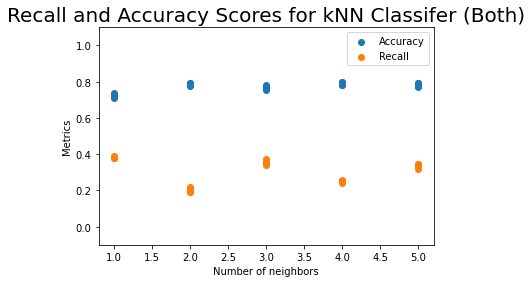

In [28]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_forboth[0]).reshape(1,-1),
           label='Accuracy')

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_forboth[1]).reshape(1,-1),
           label='Recall')

#plt.scatter(range(1,5), np.mean(knn_foracc[0], axis=1), label='Average')

# plt.plot([1,5],
#         [accuracy_score(train['Y'],baseline_pred['Y']),accuracy_score(train['Y'],baseline_pred['Y'])],
#         label='Baseline Accuracy')

# plt.plot([1,5],
#         [recall_score(train['Y'],baseline_pred['Y']),recall_score(train['Y'],baseline_pred['Y'])],
#         label='Baseline Recall')

plt.title('Recall and Accuracy Scores for kNN Classifer (Both)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Metrics')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [29]:
np.mean(metrics[1][0])

0.300739120988485

In [30]:
knn_forboth[0][2]

array([0.77907407, 0.76740741, 0.75296296, 0.78148148, 0.7612963 ])

## PCA and kNN

In [31]:
def knn_5(j, splits=5, features=features2):
    '''goes through k in range(1,j+1) on kNN models on training set
    does PCA first to reduce dimensions
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    
    accs=np.zeros((j,splits))
    recs = np.zeros((j,splits))
    for i in range(j):
        x=0
        for train_index, test_index in kfold.split(train[features], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = Pipeline([
                ('scale', StandardScaler()),
                ('pca', PCA()),
                ('knn', KNeighborsClassifier(n_neighbors=i+1))
                            ])
            kNN.fit(
                train.iloc[train_index][features],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][features]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [32]:
metrics_5=knn_5(20)

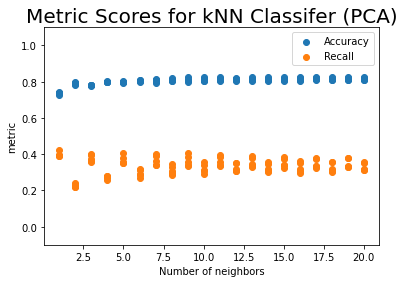

In [33]:
#plt.figure(figsize=(8,6))

plt.scatter(make_x(20),
           metrics_5[0],
           label='Accuracy')

plt.scatter(make_x(20),
           metrics_5[1],
           label='Recall')

plt.title('Metric Scores for kNN Classifer (PCA)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('metric')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [36]:
print('Acc and rec for k=3')
print(np.round(np.mean(metrics_5[0][2]),4))
print(np.round(np.mean(metrics_5[1][2]),4))

Acc and rec for k=3
0.7815
0.3789


In [37]:
print('Acc and rec for k=1')
print(np.round(np.mean(metrics_5[0][0]),4))
print(np.round(np.mean(metrics_5[1][0]),4))

Acc and rec for k=1
0.7368
0.4005


## Testing models against validation data

Model using all the TE features

In [38]:
kNN1=KNeighborsClassifier(n_neighbors=1)

In [46]:
kNN1.fit(train[features2],train['Y'])

pred1=kNN1.predict(val[features2])

In [43]:
print('Accuracy: ' + str(np.round(accuracy_score(pred1,val['Y']),4)) )
print('Recall: ' + str(np.round(recall_score(pred1,val['Y']),4)))

Accuracy: 0.6863
Recall: 0.296


Model using all the TE features, and scale/PCA first

In [44]:
kNN2=Pipeline([
                ('scale', StandardScaler()),
                ('pca', PCA()),
                ('knn', KNeighborsClassifier(n_neighbors=3))
                            ])

In [47]:
kNN2.fit(train[features2],train['Y'])

pred2=kNN2.predict(val[features2])

In [48]:
print('Accuracy: ' + str(np.round(accuracy_score(pred2,val['Y']),4)) )
print('Recall: ' + str(np.round(recall_score(pred2,val['Y']),4)))

Accuracy: 0.7753
Recall: 0.4899
